In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [6]:
%run period.py 64 1 0.25 --model_type gru --sim_type period/even/noise0

/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/period/even/noise0/gru_064_x1_2m03_drop25


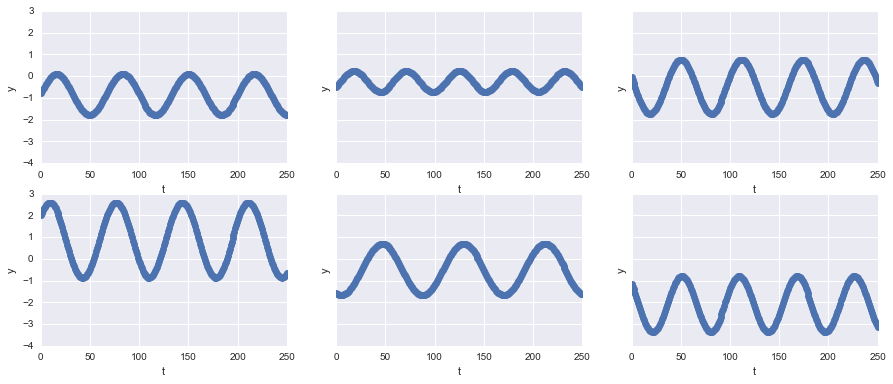

In [7]:
fig, ax = plt.subplots(2, 3, sharey=True)
for j in range(6):
#    i = np.where(y == j)[0][0]
    i = j
    ax.ravel()[j].plot(np.linspace(0, n_max, n_max), X[i], 'o')
#    ax.ravel()[j].plot(X[i][:, 0], X[i][:, 1], 'o')
    ax.ravel()[j].set(xlabel="t", ylabel="y")

In [16]:
?sample_data.periodic

In [8]:
%%time
predict_train = model.predict(X[train])
predict_test = model.predict(X[test])

CPU times: user 3min 24s, sys: 23.1 s, total: 3min 47s
Wall time: 1min 2s


In [20]:
np.mean(np.abs(predict_train - Y[train]), 0)

array([ 0.02963259,  0.02021731,  0.08141797,  0.02183573])

In [ ]:
%%time
from gatspy.periodic import LombScargle, LombScargleFast

pred_gatspy = np.zeros(N_test)
for i in range(N_test):
    opt_args = {'period_range': (0.1, 0.9 * (X[test[i]][-1, 0] - X[test[i]][0, 0])), 'quiet': True}
    model_gatspy = LombScargle(fit_period=True, optimizer_kwds=opt_args)#, silence_warnings=True)
    pred_gatspy[i] = 1. / model_gatspy.fit(X[test[i]][:, 0], X[test[i]][:, 1]).best_period

In [ ]:
model_gatspy._best_params(2 * np.pi / model_gatspy.best_period)

In [ ]:
model_gatspy._

In [ ]:
sns.jointplot(pred_keras - testY, pred_gatspy - testY)

In [ ]:
print(np.median((pred_keras - testY) ** 2))
print(np.median((pred_gatspy - testY) ** 2))